In [ ]:
# potential questions
#Can you predict the probability of rain using weather data obtained from a single station in the previous 24, 36 or 48 hours?
#How does the addition of data recorded by neighbouring stations affect the accuracy of the model?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#don't run unless you messed with dataset file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE

import seaborn as SNS

In [ ]:
zip_path = "/content/drive/My Drive/Colab Notebooks/Personal Projects/archive.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
os.listdir(extract_path)

['station_list.csv',
 'aggregated_hourly_data.csv',
 'Data_Licence.txt',
 'Data_Licence.pdf',
 'KeyHourly.txt',
 'Stations']

In [ ]:
extracted_path = "/content/dataset"
station_list_path = os.path.join(extracted_path, "station_list.csv")
df_stations = pd.read_csv(station_list_path)
print("Station List")
df_stations.head()

Station List


,Unnamed: 0,County,Station ID,Station name,Height,Easting,Northing,Latitude,Longitude
0,0,Dublin,175,phoenix_park,48,309915,236070,532149,62059
1,1,Galway,275,mace_head,21,73400,232276,531933,95403
2,2,Carlow,375,oak_park,62,273000,179500,525140,65455
3,3,Clare,518,shannon_airport,15,137900,160300,524125,85505
4,4,Dublin,532,dublin_airport,71,316900,243400,532540,61427


In [ ]:
hourly_data_path = os.path.join(extracted_path, "aggregated_hourly_data.csv")
df_hourly = pd.read_csv(hourly_data_path)
print("Hourly Weather:")
df_hourly.head()
df_hourly['st_name'].unique()

Hourly Weather:


array(['phoenix_park', 'mace_head', 'oak_park', 'shannon_airport',
       'dublin_airport', 'moore_park', 'ballyhaise', 'sherkinisland',
       'mullingar', 'roches_point', 'newport', 'markree', 'dunsany',
       'gurteen', 'malin_head', 'johnstownii', 'mt_dillon', 'finner',
       'claremorris', 'valentia_observatory', 'belmullet', 'casement',
       'cork_airport', 'knock_airport'], dtype=object)

In [ ]:
#clean
df_hourly_clean = df_hourly.drop(columns = ['Unnamed: 0'])
df_hourly_clean['date'] = pd.to_datetime(df_hourly_clean['date'])
missing_values = df_hourly_clean.isnull().sum()

In [ ]:
#drop columns missing excessive values, and fill it in with forward fill, then check missing again

columns_to_drop = ['ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt']
df_hourly_clean = df_hourly_clean.drop(columns=columns_to_drop)
df_hourly_clean = df_hourly_clean.fillna(method='ffill')
df_hourly_clean.isnull().sum()

<ipython-input-8-e6cda5f88ce5>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_clean = df_hourly_clean.fillna(method='ffill')


,0
date,0
ind,0
rain,0
ind.1,0
temp,0
ind.2,0
wetb,0
dewpt,0
vappr,0
rhum,0


In [ ]:
##Can you predict the probability of rain using weather data obtained from a single station in the previous 24, 36 or 48 hours?
#chose to work on dublin airport
df_dublin = df_hourly_clean[df_hourly_clean['st_name'] == "dublin_airport"]

df_dublin = df_dublin.reset_index(drop=True)
df_dublin.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,county,st_id,st_name,st_height,st_lat,st_long
0,2007-12-31 02:00:00,0,0.0,0,9.2,0,7.9,6.4,9.6,83.0,1023.8,Dublin,532,dublin_airport,71,532540,61427
1,2007-12-31 03:00:00,0,0.0,0,9.4,0,7.7,5.6,9.1,78.0,1023.5,Dublin,532,dublin_airport,71,532540,61427
2,2007-12-31 04:00:00,0,0.0,0,9.5,0,7.8,5.7,9.2,78.0,1023.1,Dublin,532,dublin_airport,71,532540,61427
3,2007-12-31 05:00:00,0,0.0,0,9.4,0,8.0,6.4,9.6,81.0,1022.9,Dublin,532,dublin_airport,71,532540,61427
4,2007-12-31 06:00:00,0,0.0,0,8.7,0,7.8,6.7,9.9,88.0,1022.6,Dublin,532,dublin_airport,71,532540,61427


<ipython-input-18-8fda50810798>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dublin[f'temp_lag_{i}'] = df_dublin['temp'].shift(i)


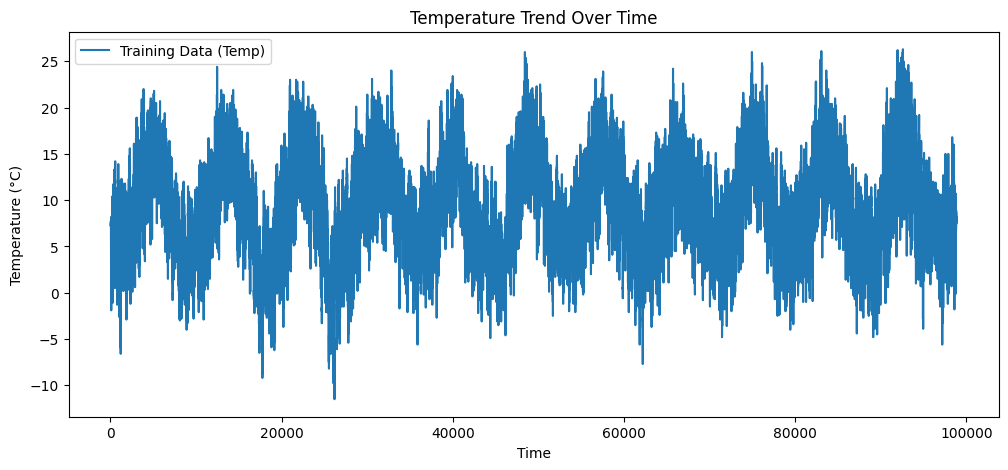

In [ ]:
#train test splits, 80-20
lags = [1, 3, 6, 12, 24]
for i in lags:
    df_dublin[f'temp_lag_{i}'] = df_dublin['temp'].shift(i)

df_dublin = df_dublin.dropna()

X = df_dublin[['temp_lag_1', 'temp_lag_3', 'temp_lag_6', 'temp_lag_12', 'temp_lag_24']]
y = df_dublin['temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

plt.figure(figsize=(12, 5))
plt.plot(y_train, label="Training Data (Temp)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend Over Time")
plt.legend()
plt.show()


In [ ]:
#ADF test - stat test to determine if a time series is stationary or not
# if a time series is stationary, its stat props (mean, variance) do not change over time, checking seasonality of weather
adf_test = adfuller(y_train)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

#if p value < 0.05, data is stationary
if adf_test[1] < 0.05:
  print ("the time series is stationary")
else:
  print('not stationary, and need to difference')

ADF Statistic: -10.3448827532393
P-value: 2.626771164639147e-18
the time series is stationary


In [ ]:
arima_model = ARIMA(y_train, order=(2, 0, 2))
arima_result = arima_model.fit()

print(arima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                98764
Model:                 ARIMA(2, 0, 2)   Log Likelihood             -124281.667
Date:                Sat, 22 Feb 2025   AIC                         248575.334
Time:                        00:39:27   BIC                         248632.337
Sample:                             0   HQIC                        248592.643
                              - 98764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5557      0.102     94.051      0.000       9.357       9.755
ar.L1          1.6206      0.007    228.894      0.000       1.607       1.635
ar.L2         -0.6391      0.007    -92.252      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


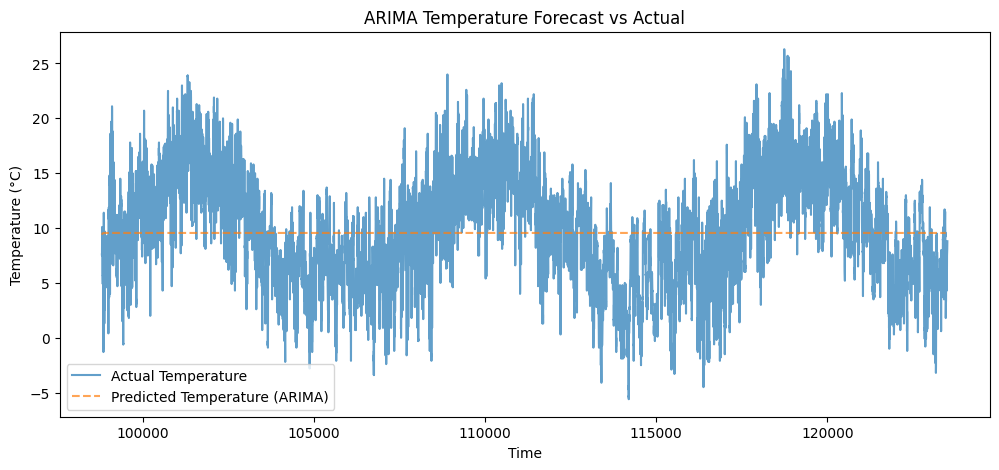

In [ ]:
#use arima model to predict temperatures for test period
y_pred_arima = pd.Series(arima_result.forecast(steps=len(y_test)), index=y_test.index)
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label="Actual Temperature", alpha=0.7)
plt.plot(y_pred_arima.index, y_pred_arima.values, label="Predicted Temperature (ARIMA)", alpha=0.7, linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("ARIMA Temperature Forecast vs Actual")
plt.legend()
plt.show()
#ARIMA model lacts SEASONAL ADJUSTMENTS so we need to use SARIMA model isntead (accounts for seasonal patterns)

New Train/Test Split Sizes: (4, 5) (1, 5) (4,) (1,)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting paramete

Optimization terminated successfully.
         Current function value: 0.087008
         Iterations: 38
         Function evaluations: 3952


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


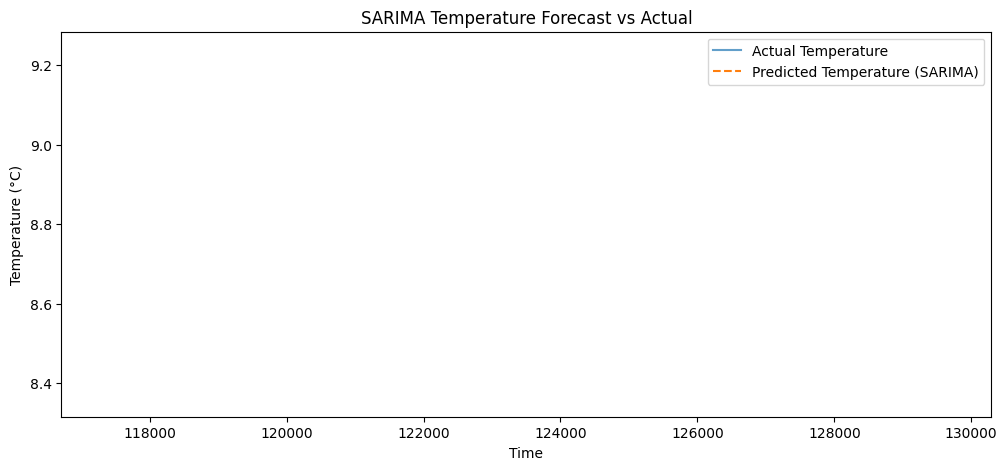

In [ ]:
# Reduce dataset to last 30,000 rows, takes like 40 min don't run
df_dublin_small = df_dublin.iloc[-30000:]

X_small = df_dublin_small[['temp_lag_1', 'temp_lag_3', 'temp_lag_6', 'temp_lag_12', 'temp_lag_24']]
y_small = df_dublin_small['temp']

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, shuffle=False)

print("New Train/Test Split Sizes:", X_train_small.shape, X_test_small.shape, y_train_small.shape, y_test_small.shape)

# Train SARIMA model with smaller dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(y_train_small, order=(2,0,2), seasonal_order=(2,0,2,24))
sarima_result = sarima_model.fit(method='powell')

y_pred_sarima = pd.Series(sarima_result.forecast(steps=len(y_test_small)), index=y_test_small.index)

plt.figure(figsize=(12, 5))
plt.plot(y_test_small.index, y_test_small.values, label="Actual Temperature", alpha=0.7)
plt.plot(y_pred_sarima.index, y_pred_sarima.values, label="Predicted Temperature (SARIMA)", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("SARIMA Temperature Forecast vs Actual")
plt.legend()
plt.show()


In [ ]:
#Use of LSTM, handle long term dependencies better than SARIMA
#Long short term memory are RNN, specifically for sequential data like time series

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_dublin[['temp']])

#create sequences of past 24 hours to predict next hour
def create_sequences(data, seq_length = 24):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X), np.array(y)

seq_length = 48
X_lstm, y_lstm = create_sequences(scaled_data, seq_length)

split_index = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]
print("LSTM Train/Test Shapes:", X_train_lstm.shape, X_test_lstm.shape, y_train_lstm.shape, y_test_lstm.shape)

LSTM Train/Test Shapes: (98725, 24, 1) (24682, 24, 1) (98725, 1) (24682, 1)


In [ ]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(24, 1)),  # 50 neurons, relu activation
    LSTM(50, activation='relu', return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


model.summary()

Epoch 1/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - loss: 0.0105 - val_loss: 9.7367e-04
Epoch 2/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 144s 33ms/step - loss: 5.5456e-04 - val_loss: 4.5574e-04
Epoch 3/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - loss: 5.0900e-04 - val_loss: 4.7197e-04
Epoch 4/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 138s 31ms/step - loss: 4.8759e-04 - val_loss: 4.4883e-04
Epoch 5/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - loss: 4.7225e-04 - val_loss: 5.0628e-04
Epoch 6/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - loss: 4.7676e-04 - val_loss: 4.3902e-04
Epoch 7/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 144s 31ms/step - loss: 4.7579e-04 - val_loss: 4.7248e-04
Epoch 8/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 149s 33ms/step - loss: 4.7045e-04 - val_loss: 4.4710e-04
Epoch 9/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 90s 29ms/step - loss: 4.6003e-04 - val_loss: 4.3487e-04
Epoch 10/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 95s 31ms/step - loss: 4.5598e-04 - val_loss: 4.3886e-04


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 24, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

772/772 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step


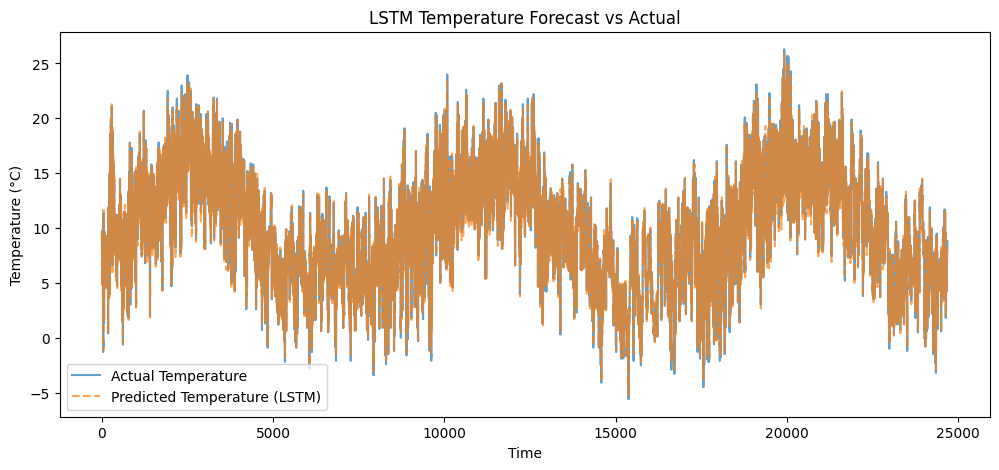

In [ ]:
y_pred_lstm = model.predict(X_test_lstm)

y_pred_lstm = scaler.inverse_transform(y_pred_lstm)  # Convert back from normalized scale
y_test_lstm_original = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm_original, label="Actual Temperature", alpha=0.7)
plt.plot(y_pred_lstm, label="Predicted Temperature (LSTM)", linestyle="dashed", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Temperature Forecast vs Actual")
plt.legend()
plt.show()


In [ ]:
y_pred_sarima = sarima_result.forecast(steps=len(y_test_small))

# Calculate RMSE & MAE for SARIMA
rmse_sarima = np.sqrt(mean_squared_error(y_test_small, y_pred_sarima))
mae_sarima = mean_absolute_error(y_test_small, y_pred_sarima)

# Calculate RMSE & MAE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_original, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_lstm_original, y_pred_lstm)

# Print the comparison
print("📊 Model Performance Comparison:")
print(f"➡ SARIMA RMSE: {rmse_sarima:.3f}, MAE: {mae_sarima:.3f}")
print(f"➡ LSTM   RMSE: {rmse_lstm:.3f}, MAE: {mae_lstm:.3f}")

📊 Model Performance Comparison:
➡ SARIMA RMSE: 0.153, MAE: 0.153
➡ LSTM   RMSE: 0.792, MAE: 0.557


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#Can I predict prob of rain using weather data from last 24, 36, 48 hour

df_dublin['rain_binary'] = (df_dublin['rain'] > 0).astype(int)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_dublin[['temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']])

def create_sequences_rain(data, labels, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Past X hours as input
        y.append(labels[i+seq_length])  # Rain label at current hour
    return np.array(X), np.array(y)
seq_length = 24
X_rain, y_rain = create_sequences_rain(scaled_features, df_dublin['rain_binary'].values, seq_length)

split_index = int(len(X_rain) * 0.8)
X_train_rain, X_test_rain = X_rain[:split_index], X_rain[split_index:]
y_train_rain, y_test_rain = y_rain[:split_index], y_rain[split_index:]


Rain Prediction Train/Test Shapes: (98725, 24, 6) (24682, 24, 6) (98725,) (24682,)


In [ ]:
model_rain = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_rain.shape[1], X_train_rain.shape[2])),
    Dropout(0.2),  # Prevents overfitting
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='tanh'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary
])

model_rain.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#train
history_rain = model_rain.fit(X_train_rain, y_train_rain, epochs=10, batch_size=32, validation_data=(X_test_rain, y_test_rain))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 144s 44ms/step - accuracy: 0.8693 - loss: 0.3538 - val_accuracy: 0.8851 - val_loss: 0.2892
Epoch 2/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 117s 36ms/step - accuracy: 0.8774 - loss: 0.3032 - val_accuracy: 0.8853 - val_loss: 0.2772
Epoch 3/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 130s 32ms/step - accuracy: 0.8806 - loss: 0.2920 - val_accuracy: 0.8879 - val_loss: 0.2745
Epoch 4/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 103s 33ms/step - accuracy: 0.8827 - loss: 0.2863 - val_accuracy: 0.8859 - val_loss: 0.2747
Epoch 5/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - accuracy: 0.8850 - loss: 0.2803 - val_accuracy: 0.8873 - val_loss: 0.2730
Epoch 6/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - accuracy: 0.8842 - loss: 0.2790 - val_accuracy: 0.8906 - val_loss: 0.2653
Epoch 7/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 102s 33ms/step - accuracy: 0.8838 - loss: 0.2803 - val_accuracy: 0.8916 - val_loss: 0.2655
Epoch 8/10
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 140s 32ms/step - accuracy: 

In [ ]:
y_pred_rain_prob = model_rain.predict(X_test_rain)

y_pred_rain = (y_pred_rain_prob > 0.3).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_rain, y_pred_rain)
precision = precision_score(y_test_rain, y_pred_rain)
recall = recall_score(y_test_rain, y_pred_rain)
f1 = f1_score(y_test_rain, y_pred_rain)

print("📊 Rain Prediction Model Performance:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f" F1-score:  {f1:.3f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
📊 Rain Prediction Model Performance:
Accuracy:  0.891
Precision: 0.669
Recall:    0.287
 F1-score:  0.401


In [ ]:
#recall value too high and f1 score not great
# use smote because training date says "no rain" too often, very low recall
# False Negatives a lot, smote generates synthetic examples of rain class to learn better

X_train_rain_reshaped = X_train_rain.reshape(X_train_rain.shape[0], -1)

# Apply SMOTE to balance rain/no rain cases
smote = SMOTE(random_state=42)
X_train_rain_bal, y_train_rain_bal = smote.fit_resample(X_train_rain_reshaped, y_train_rain)

# Reshape back to 3D for LSTM
X_train_rain_bal = X_train_rain_bal.reshape(X_train_rain_bal.shape[0], 24, X_train_rain.shape[2])

print("Balanced Dataset Class Distribution:", np.bincount(y_train_rain_bal))
#train
history_rain_bal = model_rain.fit(
    X_train_rain_bal, y_train_rain_bal,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_rain, y_test_rain)
)

Balanced Dataset Class Distribution: [85872 85872]
Epoch 1/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 183s 34ms/step - accuracy: 0.8001 - loss: 0.4320 - val_accuracy: 0.7797 - val_loss: 0.4594
Epoch 2/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 189s 32ms/step - accuracy: 0.8133 - loss: 0.4082 - val_accuracy: 0.7869 - val_loss: 0.4436
Epoch 3/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 196s 31ms/step - accuracy: 0.8187 - loss: 0.3987 - val_accuracy: 0.8127 - val_loss: 0.4053
Epoch 4/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 165s 31ms/step - accuracy: 0.8242 - loss: 0.3877 - val_accuracy: 0.8127 - val_loss: 0.3925
Epoch 5/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 169s 31ms/step - accuracy: 0.8274 - loss: 0.3815 - val_accuracy: 0.8163 - val_loss: 0.3877
Epoch 6/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 207s 32ms/step - accuracy: 0.8345 - loss: 0.3712 - val_accuracy: 0.7559 - val_loss: 0.5088
Epoch 7/10
5367/5367 ━━━━━━━━━━━━━━━━━━━━ 165s 31ms/step - accuracy: 0.8390 - loss: 0.3651 - val_accuracy: 0.8095 - val_loss: 0.4034
Epoch 8/10
5367/53

In [ ]:
y_pred_rain_prob_bal = model_rain.predict(X_test_rain)

# Convert probabilities to binary labels with threshold 0.5
y_pred_rain_bal = (y_pred_rain_prob_bal > 0.5).astype(int)

accuracy_bal = accuracy_score(y_test_rain, y_pred_rain_bal)
precision_bal = precision_score(y_test_rain, y_pred_rain_bal)
recall_bal = recall_score(y_test_rain, y_pred_rain_bal)
f1_bal = f1_score(y_test_rain, y_pred_rain_bal)

print("📊 Rain Prediction Model Performance (After SMOTE):")
print(f"Accuracy:  {accuracy_bal:.3f}")
print(f"Precision: {precision_bal:.3f}")
print(f"Recall:    {recall_bal:.3f}")
print(f"F1-score:  {f1_bal:.3f}")

772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step
📊 Rain Prediction Model Performance (After SMOTE):
✅ Accuracy:  0.777
✅ Precision: 0.333
✅ Recall:    0.754
✅ F1-score:  0.462


In [ ]:
print("Available columns in df_stations:", df_stations.columns)


Available columns in df_stations: Index(['Unnamed: 0', 'County', 'Station ID', 'Station name', 'Height',
       'Easting', 'Northing', 'Latitude', 'Longitude'],
      dtype='object')


In [ ]:
# how does adding data from neighboring stations affect accuracy

#check 3 closest stations
df_stations.rename(columns={'Station name': 'st_name', 'Latitude': 'st_lat', 'Longitude': 'st_long'}, inplace=True)
dublin_airport = df_stations[df_stations["st_name"] == "dublin_airport"]
dublin_lat, dublin_long = dublin_airport["st_lat"].values[0], dublin_airport["st_long"].values[0]
def calculate_distance(lat1, long1, lat2, long2):
    return np.sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)
df_stations["distance"] = df_stations.apply(
    lambda row: calculate_distance(dublin_lat, dublin_long, row["st_lat"], row["st_long"]),
    axis=1)
nearest_stations = df_stations[df_stations["st_name"] != "dublin_airport"].sort_values(by="distance").head(3)

# Print the nearest stations
print(" Nearest Stations to Dublin Airport:")
print(nearest_stations[["st_name", "distance"]])


 Nearest Stations to Dublin Airport:
         st_name     distance
0   phoenix_park   743.172255
21      casement  1393.430658
12       dunsany  2561.712318


In [ ]:
#merge based on date
stations_to_merge = ["dublin_airport", "phoenix_park", "casement", "dunsany"]
df_selected_stations = df_hourly_clean[df_hourly_clean["st_name"].isin(stations_to_merge)]
df_merged = df_selected_stations.pivot(index="date", columns="st_name", values=["rain", "temp", "wetb", "dewpt", "vappr", "rhum", "msl"])
df_merged.columns = ['_'.join(col).strip() for col in df_merged.columns]
df_merged.reset_index(inplace=True)

print("Merged Dataset (Dublin Airport + 3 Nearest Stations):")
print(df_merged.head())


Merged Dataset (Dublin Airport + 3 Nearest Stations):
                 date  rain_casement  rain_dublin_airport  rain_dunsany  \
0 2007-12-31 02:00:00            0.0                  0.0           0.0   
1 2007-12-31 03:00:00            0.0                  0.0           0.0   
2 2007-12-31 04:00:00            0.0                  0.0           0.0   
3 2007-12-31 05:00:00            0.0                  0.0           0.0   
4 2007-12-31 06:00:00            0.0                  0.0           0.0   

   rain_phoenix_park  temp_casement  temp_dublin_airport  temp_dunsany  \
0                0.0            8.9                  9.2           8.8   
1                0.0            9.2                  9.4           8.9   
2                0.0            9.0                  9.5           8.9   
3                0.0            9.1                  9.4           9.0   
4                0.0            9.2                  8.7           9.3   

   temp_phoenix_park  wetb_casement  ...  vappr_du

In [ ]:
print("Available Columns in df_multi:", df_multi.columns)


Available Columns in df_multi: Index(['date', 'rain_casement', 'rain_dublin_airport', 'rain_dunsany',
       'rain_phoenix_park', 'temp_casement', 'temp_dublin', 'temp_dunsany',
       'temp_phoenix_park', 'wetb_casement', 'wetb_dublin', 'wetb_dunsany',
       'wetb_phoenix_park', 'dewpt_casement', 'dewpt_dublin', 'dewpt_dunsany',
       'dewpt_phoenix_park', 'vappr_casement', 'vappr_dublin_airport',
       'vappr_dunsany', 'vappr_phoenix_park', 'rhum_casement', 'rhum_dublin',
       'rhum_dunsany', 'rhum_phoenix_park', 'msl_casement', 'msl_dublin',
       'msl_dunsany', 'msl_phoenix_park'],
      dtype='object')


In [ ]:
#clean the data AGAIN
df_multi = df_multi.rename(columns={
    'temp_phoenix_park': 'temp_phoenix',
    'wetb_phoenix_park': 'wetb_phoenix',
    'dewpt_phoenix_park': 'dewpt_phoenix',
    'rhum_phoenix_park': 'rhum_phoenix',
    'msl_phoenix_park': 'msl_phoenix',
    'vappr_phoenix_park': 'vappr_phoenix'
})

features_multi = [
    'temp_casement', 'temp_dublin', 'temp_dunsany', 'temp_phoenix',
    'wetb_casement', 'wetb_dublin', 'wetb_dunsany', 'wetb_phoenix',
    'dewpt_casement', 'dewpt_dublin', 'dewpt_dunsany', 'dewpt_phoenix',
    'rhum_casement', 'rhum_dublin', 'rhum_dunsany', 'rhum_phoenix',
    'msl_casement', 'msl_dublin', 'msl_dunsany', 'msl_phoenix',
    'vappr_casement', 'vappr_dublin_airport', 'vappr_dunsany', 'vappr_phoenix'
]

missing_cols = [col for col in features_multi if col not in df_multi.columns]
if missing_cols:
    print("Missing Columns:", missing_cols)
else:
    print("All required columns exist.")

scaler_multi = MinMaxScaler()
scaled_features_multi = scaler_multi.fit_transform(df_multi[features_multi])

print("Feature scaling completed successfully.")


def create_sequences_multi(data, labels, seq_length=24):
    X_multi, y_multi = [], []
    for i in range(len(data) - seq_length):
        X_multi.append(data[i:i+seq_length])
        y_multi.append(labels[i+seq_length])
    return np.array(X_multi), np.array(y_multi)

rain_labels_multi = df_multi['rain_dublin_airport'].values
seq_length = 24
X_rain_multi, y_rain_multi = create_sequences_multi(scaled_features_multi, rain_labels_multi, seq_length)

split_idx_multi = int(len(X_rain_multi) * 0.8)
X_train_multi, X_test_multi = X_rain_multi[:split_idx_multi], X_rain_multi[split_idx_multi:]
y_train_multi, y_test_multi = y_rain_multi[:split_idx_multi], y_rain_multi[split_idx_multi:]

print("Multi-Station Rain Prediction Train/Test Shapes:", X_train_multi.shape, X_test_multi.shape, y_train_multi.shape, y_test_multi.shape)


All required columns exist.
Feature scaling completed successfully.
Multi-Station Rain Prediction Train/Test Shapes: (98783, 24, 24) (24696, 24, 24) (98783,) (24696,)


In [ ]:
model_multi = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='tanh'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary
])

model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_multi = model_multi.fit(
    X_train_multi, y_train_multi,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_multi, y_test_multi)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 129s 37ms/step - accuracy: 0.8651 - loss: 0.2743 - val_accuracy: 0.8526 - val_loss: 0.2093
Epoch 2/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 97s 31ms/step - accuracy: 0.8581 - loss: 0.2156 - val_accuracy: 0.8367 - val_loss: 0.2070
Epoch 3/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 148s 33ms/step - accuracy: 0.8571 - loss: 0.1988 - val_accuracy: 0.8565 - val_loss: 0.1814
Epoch 4/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - accuracy: 0.8562 - loss: 0.1920 - val_accuracy: 0.8497 - val_loss: 0.1839
Epoch 5/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 146s 33ms/step - accuracy: 0.8535 - loss: 0.1972 - val_accuracy: 0.8477 - val_loss: 0.2047
Epoch 6/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - accuracy: 0.8574 - loss: 0.1884 - val_accuracy: 0.8647 - val_loss: 0.1803
Epoch 7/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 144s 34ms/step - accuracy: 0.8565 - loss: 0.1899 - val_accuracy: 0.8580 - val_loss: 0.1690
Epoch 8/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - accuracy: 0.

In [ ]:
y_pred_multi_lower_thresh = (y_pred_multi_prob > 0.3).astype(int)

accuracy_lower = accuracy_score(y_test_multi, y_pred_multi_lower_thresh)
precision_lower = precision_score(y_test_multi, y_pred_multi_lower_thresh)
recall_lower = recall_score(y_test_multi, y_pred_multi_lower_thresh)
f1_lower = f1_score(y_test_multi, y_pred_multi_lower_thresh)

print("Performance with Lower Threshold (0.3):")
print(f"Accuracy:  {accuracy_lower:.3f}")
print(f"Precision: {precision_lower:.3f}")
print(f"Recall:    {recall_lower:.3f}")
print(f"F1-score:  {f1_lower:.3f}")

Performance with Lower Threshold (0.3):
Accuracy:  0.892
Precision: 0.693
Recall:    0.274
F1-score:  0.393


In [ ]:
#multi station LSTM model
#accuracy: 89.2
#precision: 0.693
#recall: 0.274
# f1 score: 0.393
#issues with recall and f1 score, but model runtime too long, no more storage

#single station
#accuracy: 0.777
#precision: 0.333
#recall: 0.754
# f1 score: 0.462


Unique values in y_test_multi after binarization: [0 1]


772/772 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step


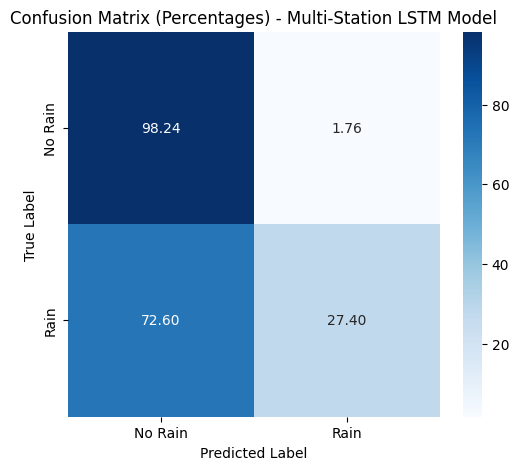

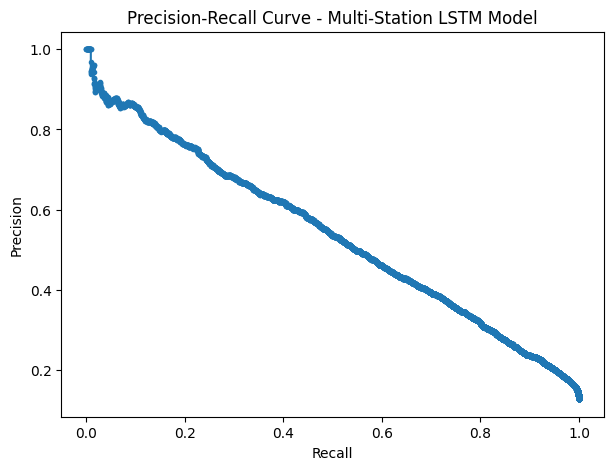

In [ ]:
#visualize
# Predict probabilities
y_pred_multi_prob = model_multi.predict(X_test_multi)
y_pred_multi = (y_pred_multi_prob > 0.3).astype(int)  # Apply 0.3 threshold for rain

cm = confusion_matrix(y_test_multi, y_pred_multi)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
SNS.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentages) - Multi-Station LSTM Model")
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test_multi, y_pred_multi_prob)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Multi-Station LSTM Model")
plt.show()

In [ ]:
#yes, but with limitations. using only dublin airport data, the model got high recall (75.4%), meaning it detected most rain events,
# but precision was low (33.3%), meaning lots of false alarms. so yes, we can predict rain using a single station, but it's not perfect.

#adding neighboring stations makes the model more accurate overall but worse at catching actual rain. accuracy improved (77.7% → 89.2%),
# and precision jumped (33.3% → 69.3%), so it predicts rain less often but more confidently. the problem is recall dropped hard (75.4% → 27.4%),
#meaning it missed way more actual rain events. basically, adding stations makes the model more conservative, but it also ignores real rain cases.

#so can we predict rain? yes, but not perfectly. single-station data is better at detecting rain but gives false alarms. multi-station data
#reduces false alarms but misses actual rain. lowering the probability threshold (0.3) helped recall a little (18.3% → 27.4%), but
# predicting rain is still tricky because rain is rare in the dataset.

#if you want to avoid missing rain, stick with a single station and lower the threshold. if you want fewer false alarms,
#use multiple stations, but expect to miss some rain. if we want to push recall up without tanking precision, smote or another
#balancing method might help. wanna test more ideas or are we calling it done?